In [1]:
import fastjet as fj
from lundplane import pylundplane as lund
from mptools import pymptools as mpt

from tqdm import tqdm
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
from tqdm import tnrange, tqdm_notebook

In [2]:
aleph_file="/Volumes/two/data/aleph/LEP1Data1992_recons_aftercut-001.aleph"
mpt.dump(aleph_file, 2, False);
# mpt.dump(aleph_file, -1, True);

In [3]:
# print the banner first
fj.ClusterSequence.print_banner()
print()
# set up our jet definition and a jet selector
jet_R0 = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
#jet_selector = fj.SelectorPtMin(0.0) & fj.SelectorPtMax(200.0) & fj.SelectorAbsEtaMax(1)
jet_selector = fj.SelectorPtMin(0.0) & fj.SelectorPtMax(200.0)

In [5]:
%%time
all_jets = []
reader = mpt.Reader(aleph_file)
pbar = tqdm_notebook(total=14024)
while reader.read_next_event():
    pbar.update()
    e = reader.get_event()
    parts = []
    # aleph_parts = e.get_particles()
    # print(len(aleph_parts))
    for p in e.get_particles():
        psj = fj.PseudoJet(p.px(), p.py(), p.pz(), p.e())
        parts.append(psj)
    jets = jet_selector(jet_def(parts))
    all_jets.extend(jets)

CPU times: user 22 s, sys: 629 ms, total: 22.6 s
Wall time: 22.6 s


In [6]:
%%time
jet_def_lund = fj.JetDefinition(fj.cambridge_algorithm, 1.0)
lund_gen = lund.LundGenerator(jet_def_lund)
lunds = [lund_gen.result(j) for j in all_jets]

CPU times: user 1.15 s, sys: 332 ms, total: 1.49 s
Wall time: 1.56 s


In [7]:
%%time
log_kt = []
log_1oDelta = []
for l in lunds:
    for s in l:
        log_kt.append(math.log(s.kt()))
        log_1oDelta.append(math.log(1./s.Delta()))

CPU times: user 1.75 s, sys: 243 ms, total: 2 s
Wall time: 2.02 s


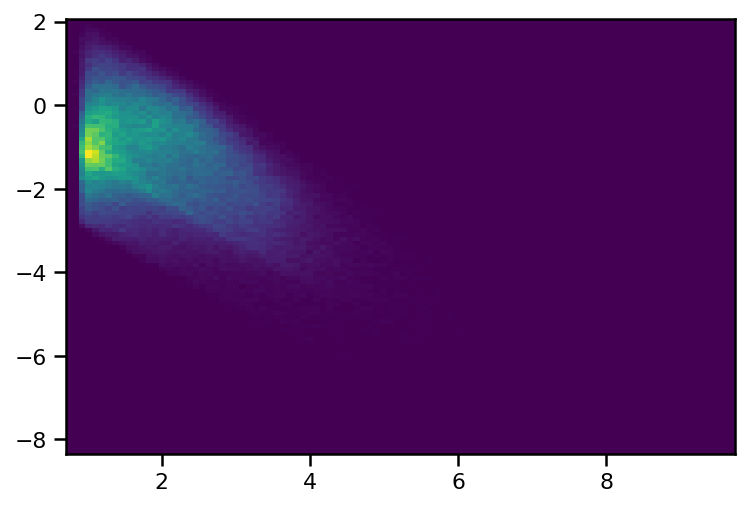

In [8]:
b, x, y, ax = plt.hist2d(log_1oDelta, log_kt, bins=100)

In [9]:
%%time
jet_selector_10 = fj.SelectorPtMin(10.0) & fj.SelectorPtMax(200.0)
jets_10 = jet_selector_10(all_jets)
lunds = [lund_gen.result(j) for j in jets_10]

CPU times: user 553 ms, sys: 357 ms, total: 911 ms
Wall time: 1.02 s


In [10]:
%%time
log_kt = []
log_1oDelta = []
for l in lunds:
    for s in l:
        log_kt.append(math.log(s.kt()))
        log_1oDelta.append(math.log(1./s.Delta()))

CPU times: user 859 ms, sys: 238 ms, total: 1.1 s
Wall time: 1.17 s


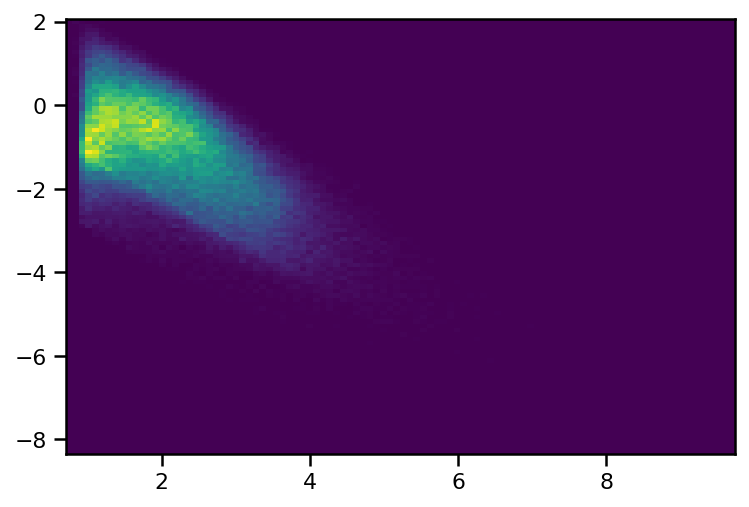

In [11]:
b, x, y, ax = plt.hist2d(log_1oDelta, log_kt, bins=100)

In [12]:
len(jets_10)

29272